# **4th Order Pohlhausen on Boundary Layer Approximation Analysis of NACA 2410 Airfoil**

---
**Authors**
- Cahya Amalinadhi P
- Rafael Stevenson

**References**
- F. M. White, Viscous Fluid Flow, Singapore: Mc Graw Hill, 2006
- A. M. Kuethe and C. -Y. Chow, Foundations of Aerodynamics, Canada: John Wiley & Sons, Inc, 1998
- H. Schlichting, Boundary Layer Theory (7th ed.), New York: Mc Graw Hill
- Pohlhausen Separation: http://farside.ph.utexas.edu/teaching/336L/Fluidhtml/node118.html
- Transition Location: The One-Step Method of Michel (1952)

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

**Fungsi-fungsi**

In [2]:
# Read airfoil
def readAirfoil(airfoilPath):
    Xb = []
    Yb = []
   
    f = open(airfoilPath, "r")
    for data in f:
        splittedData = data.rstrip().split(",")
        Xb.append(float(splittedData[0]))
        Yb.append(float(splittedData[1]))

    Xb = np.array(Xb[::-1], dtype=float)
    Yb = np.array(Yb[::-1], dtype=float)

    return (Xb, Yb)


# Vortex Panel Method
def VortexPanelMethod(aoa, Gee, Xb, Yb):
    # Initialization
    M = len(Xb)-1
    ALPHA = aoa*math.pi/180.

    X = np.zeros((M,1), dtype=float)
    Y = np.zeros((M,1), dtype=float)
    S = np.zeros((M,1), dtype=float)
    theta = np.zeros((M,1), dtype=float)
    sine = np.zeros((M,1), dtype=float)
    cosine = np.zeros((M,1), dtype=float)
    RHS = np.zeros((M+1,1), dtype=float)
    RHSC = np.zeros((M+1,1), dtype=float)
    CN1 = np.zeros((M,M), dtype=float)
    CN2 = np.zeros((M,M), dtype=float)
    CT1 = np.zeros((M,M), dtype=float)
    CT2 = np.zeros((M,M), dtype=float)
    AN = np.zeros((M+1,M+1), dtype=float)
    AT = np.zeros((M,M+1), dtype=float)
    V = np.zeros((M,1))
    CP = np.zeros((M,1))


    # Geometrical profile
    for i in range(M):
        X[i] = 0.5*(Xb[i+1] + Xb[i])
        Y[i] = 0.5*(Yb[i+1] + Yb[i])
        S[i] = math.sqrt((Xb[i+1]-Xb[i])**2 + (Yb[i+1]-Yb[i])**2)
        theta[i] = math.atan2(Yb[i+1]-Yb[i], Xb[i+1]-Xb[i])
        sine[i] = math.sin(theta[i])
        cosine[i] = math.cos(theta[i])
        RHS[i] = math.sin(theta[i]-ALPHA)+Gee[i]
        RHSC[i] = math.cos(theta[i]-ALPHA)

    # Coefficients
    for i in range(M):
        for j in range(M):
            if i==j:
                CN1[i,j] = -1.0
                CN2[i,j] = 1.0
                CT1[i,j] = math.pi/2.0
                CT2[i,j] = math.pi/2.0
            else:
                A = -(X[i]-Xb[j])*cosine[j] - (Y[i]-Yb[j])*sine[j]
                B = (X[i]-Xb[j])**2 + (Y[i]-Yb[j])**2
                C = math.sin(theta[i]-theta[j])
                D = math.cos(theta[i]-theta[j])
                E = (X[i]-Xb[j])*sine[j] - (Y[i]-Yb[j])*cosine[j]
                F = math.log(1 + S[j]*(S[j]+2*A)/B)
                G = math.atan2(E*S[j], B+A*S[j])
                P = (X[i]-Xb[j])*math.sin(theta[i]-2*theta[j]) + (Y[i]-Yb[j])*math.cos(theta[i]-2*theta[j])
                Q = (X[i]-Xb[j])*math.cos(theta[i]-2*theta[j]) - (Y[i]-Yb[j])*math.sin(theta[i]-2*theta[j])

                CN2[i,j] = D + 0.5*Q*F/S[j] - (A*C + D*E)*G/S[j]
                CN1[i,j] = 0.5*D*F + C*G - CN2[i,j]
                CT2[i,j] = C + 0.5*P*F/S[j] + (A*D - C*E)*G/S[j]
                CT1[i,j] = 0.5*C*F - D*G - CT2[i,j]

    # Calculate An & RHS
    for i in range(M):
        AN[i,0] = CN1[i,0]
        AN[i,-1] = CN2[i,-1]
        AT[i,0] = CT1[i,0]
        AT[i,-1] = CT2[i,-1]
        for j in range(1,M):
            AN[i,j] = CN1[i,j] + CN2[i,j-1]
            AT[i,j] = CT1[i,j] + CT2[i,j-1]

    AN[-1,0] = 1.0
    AN[-1,-1] = 1.0
    for j in range(1,M):
        AN[-1,j] = 0.0
    RHS[-1] = 0.0+Gee[-1]

    # Calculate gamma
    gamma = np.dot(np.linalg.inv(AN), RHS)

    # Calculation V and Cp
    for i in range(M):
        V[i] = math.cos(theta[i]-ALPHA)
        for j in range(M+1):
            V[i] += AT[i,j]*gamma[j]
            CP[i] = 1.0 - V[i]**2
            
    Vtanabs = abs(V.copy())

    return (Vtanabs, X, Y, CP, Xb, Yb)


# Boundary layer - Von Karman - 4th order Pohlhausen
def boundaryLayer(U, Vtan, X, Y):
    # Initialization
    miu = 0.0000181206
    rho = 1.225
    nu = miu/rho
    Uin = Vtan*U
    M = len(X)
    MP1 = M+1

    # cari titik stagnasi
    sl = np.where(Uin==np.amin(Uin))[0][0]
    su = sl

    # ------------------------------------------------------------------------ #    
    # CALCULATE MOMENTUM THICKNESS (TETA)
    teta = np.zeros((M, 1), dtype=float)
    
    # Upper airfoil
    teta[su] = math.sqrt((0.47/6)*nu/(abs((Uin[su+1]-Uin[su])/(X[su+1]-X[su]))))
    for j in range(su+1,M):
        integral1 = 0
        for i in range(su+1,j+1):
            integral1 += (Uin[i]**5 + Uin[i-1]**5)*abs((X[i]-X[i-1]))/2
        teta[j] = math.sqrt(0.47*nu*integral1/(Uin[j]**6))
        
    # Lower airfoil
    teta[sl] = math.sqrt((0.47/6)*nu/(abs((Uin[sl-1]-Uin[sl])/(X[sl-1]-X[sl]))))
    for j in range(sl-1,-1,-1):
        integral1 = 0
        for i in range(sl-1,j-1,-1):
            integral1 += (Uin[i]**5 + Uin[i+1]**5)*abs((X[i]-X[i+1]))/2
        teta[j] = math.sqrt(0.47*nu*integral1/Uin[j]**6)
    
    # ------------------------------------------------------------------------ # 
    # CALCULATE PRESSURE GRADIENT PARAMETER (LAMDA)
    lamda = np.zeros((M, 1), dtype=float)
    
    # Upper airfoil
    lamda[su] = (((teta[su]**2)/nu)*(Uin[su+1]-Uin[su]))/abs(X[su+1]-X[su])
    for i in range(su+1,M):
        lamda[i] = (((teta[i]**2)/nu)*(Uin[i]-Uin[i-1]))/abs(X[i]-X[i-1])
        
    # Lower airfoil
    lamda[sl] = (((teta[sl]**2)/nu)*(Uin[sl-1]-Uin[sl]))/abs(X[sl-1]-X[sl])
    for i in range(sl-1,-1,-1):
        lamda[i] = (((teta[i]**2)/nu)*(Uin[i]-Uin[i+1]))/abs(X[i]-X[i+1])
    
    # ------------------------------------------------------------------------ # 
    # CALCULATE WALL SHEAR-STRESS (TAU_W) AND DISPLACEMENT THICKNESS (DELTA*)    
    L = np.zeros((M,1), dtype=float)
    H = np.zeros((M,1), dtype=float)
    K = np.zeros((M,1), dtype=float)
    Cf = np.zeros((M,1), dtype=float)
    tauw = np.zeros((M,1), dtype=float)
    delta_star = np.zeros((M,1), dtype=float)
    YBL = np.zeros((M,1), dtype=float)
    Gee = np.zeros((M+1,1), dtype=float)
    
    # Shear stress at wall
    # Upper airfoil
    for i in range(su, M):
        if lamda[i]<-12:
            lamda[i]=-12
        if lamda[i]>12:
            lamda[i]=12

        # Find
        L[i] = (2+(lamda[i]/6))*((37/315)-(lamda[i]/945)-((lamda[i]**2)/9072))
        H[i] = ((3/10)-(lamda[i]/120))/((37/315)-(lamda[i]/945)-((lamda[i]**2)/9072))
        K[i] = lamda[i]*(((37/315)-(lamda[i]/945)-((lamda[i]**2)/9072))**2)
                
        tauw[i] = L[i]*miu*Uin[i]/teta[i]
        delta_star[i] = teta[i]*H[i]
        Cf[i] = tauw[i]/(0.5*rho*Uin[i]**2)
        
    # Lower airfoil
    for i in range(sl,-1,-1):
        if lamda[i]<-12:
            lamda[i]=-12
        if lamda[i]>12:
            lamda[i]=12
            
        # Find
        L[i] = (2+(lamda[i]/6))*((37/315)-(lamda[i]/945)-((lamda[i]**2)/9072))
        H[i] = ((3/10)-(lamda[i]/120))/((37/315)-(lamda[i]/945)-((lamda[i]**2)/9072))
        K[i] = lamda[i]*(((37/315)-(lamda[i]/945)-((lamda[i]**2)/9072))**2)
        
        tauw[i] = L[i]*miu*Uin[i]/teta[i]
        delta_star[i] = teta[i]*H[i]
        Cf[i] = tauw[i]/(0.5*rho*Uin[i]**2)
        
    # ------------------------------------------------------------------------ #
    # EVALUATE SEPARATION POINTS
    # http://farside.ph.utexas.edu/teaching/336L/Fluidhtml/node118.html
    # Upper airfoil
    for i in range(su, M):
        if lamda[i]<=-0.1567:
            xsepu = X[i]
            k1 = i
            break
        else:
            xsepu = X[M-1]
            k1 = M-1
    
    # Lower airfoil
    for i in range(sl,-1,-1):
        if lamda[i]<=-0.1567:
            xsepl = X[i]
            k2 = i
            break
        else:
            xsepu = X[M-1]
            k2 = 0
            
    # Boundary layer thickness
    for i in range(M):
        if Y[i]>0:
            YBL[i] = Y[i] + delta_star[i]
        else:
            YBL[i] = Y[i] - delta_star[i]
    
    for i in range(M):
        Gee[i] = (0.03 * delta_star[i])
    Gee[-1] = Gee[0]
    
    # ------------------------------------------------------------------------ #
    # CALCULATE TRANSITION LOCATION
    # The one-step method of michel (1952)
    # Upper airfoil
    for i in range(su, M):
        Reteta = Uin[i]*teta[i]/nu
        Rex = Uin[i]*X[i]/nu
        RR = 2.9*(Rex**0.4)
        if Reteta >= RR:
            transp1=i
            break
        else:
            transp1=M-2
            
    # Lower airfoil
    for i in range(sl,-1,-1):
        Reteta = Uin[i]*teta[i]/nu
        Rex = Uin[i]*X[i]/nu
        RR = 2.9*(Rex**0.4)
        if Reteta >= RR:
            transp2=i
            break
        else:
            transp2=0
            
    return (Cf, delta_star, Gee, YBL, transp1, transp2, su, sl)
    

**Program Utama**

In [3]:
# Input
RE = 700000
rho = 1.225         # kg/m3
miu = 0.0000181206  # dynamic viscosity
aoa = 0             # angle of attack
U = RE*miu/rho      # m/s

print(f"U = {round(U, 2)} m/s")

U = 10.35 m/s


In [4]:
# Load airfoil coordinates
airfoil_path = "./data/naca2410.csv"
Xb, Yb = readAirfoil(airfoil_path)
M = len(Xb)-1

In [5]:
# Mulai iterasi
G = np.zeros((M+1, 1), dtype=float)
delta = np.zeros((M,1), dtype=float)

errorhist = []
errordelta = 100  # initial error
i = 1

while errordelta>=1e-5:
    deltaimin1=delta.copy()
    (Vtan, X, Y, Cp, Xb, Yb) = VortexPanelMethod(aoa, G, Xb, Yb)                   # Panel method
    (Cf, delta, G, YBL, transp1, transp2, su, sl) = boundaryLayer(U, Vtan, X, Y)   # Boundary Layer
    errordelta = np.sum(np.abs(delta-deltaimin1)/delta)
    if i==1:
        CP1 = Cp
    errorhist.append(errordelta)
    i+=1
    
CpPlot = -Cp

Final iteration error: 3.0549e-07


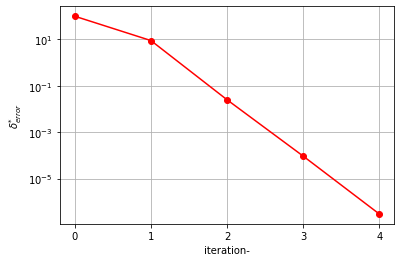

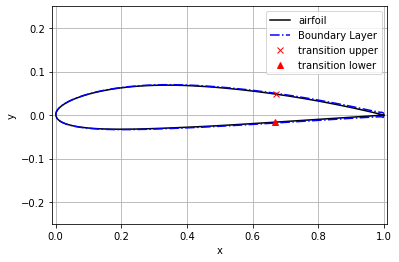

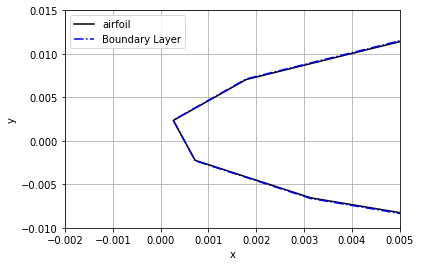

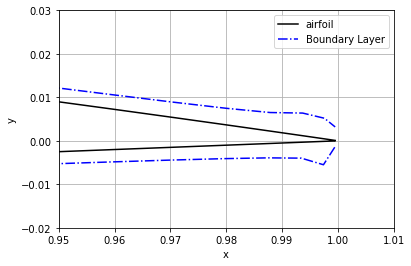

In [6]:
# Figure 1 - Plot error convergence
print(f"Final iteration error: {errorhist[-1]:.4e}")
plt.plot([int(i) for i in range(len(errorhist))], errorhist, '-or')
plt.xlabel("iteration-")
plt.ylabel("$\delta^{*}_{error}$")
plt.grid(which="both")
plt.yscale('log')
plt.xticks(np.arange(0, len(errorhist)))
plt.show()


# For boundary layer
xtransp1 = X[transp1]
ytransp1 = Y[transp1]
xtransp2 = X[transp2]
ytransp2 = Y[transp2]


# Figure 2 - Plot Boundary Layer
plt.plot(X, Y, 'k', label='airfoil')
plt.plot(X, YBL, '-.b', label='Boundary Layer')
plt.plot(xtransp1,ytransp1,'xr', label='transition upper')
plt.plot(xtransp2,ytransp2,'^r', label='transition lower')

plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.25, 0.25])
plt.legend()
plt.grid(which="both")
plt.show()

# Figure 3 - Plot Boundary Layer LE
plt.plot(X, Y, 'k', label='airfoil')
plt.plot(X, YBL, '-.b', label='Boundary Layer')

plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-0.002, 0.005])
plt.ylim([-0.01, 0.015])
plt.legend()
plt.grid(which="both")
plt.show()

# Figure 4 - Plot Boundary Layer TE
plt.plot(X, Y, 'k', label='airfoil')
plt.plot(X, YBL, '-.b', label='Boundary Layer')

plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0.95,1.01])
plt.ylim([-0.02,0.03])
plt.legend()
plt.grid(which="both")
plt.show()

**Mencari Parameter Aerodinamik**

In [7]:
# Cari Cl dan Cd dari AoA [-4.0 .. 10.0]

Cl_solver = []
Cd_solver = []

for i in range(29):
    aoa = -4+i*0.5  # degrees

    # Read data
    G = np.zeros((M+1, 1), dtype=float)
    delta = np.zeros((M,1), dtype=float)

    errorhist = []
    errordelta = 100  # initial error
    i = 1

    while errordelta>=1e-5:
        deltaimin1=delta.copy()
        (Vtan, X, Y, Cp, Xb, Yb) = VortexPanelMethod(aoa, G, Xb, Yb)                   # Panel method
        (Cf, delta, G, YBL, transp1, transp2, su, sl) = boundaryLayer(U, Vtan, X, Y)   # Boundary Layer
        errordelta = np.sum(np.abs(delta-deltaimin1)/delta)
        if i==1:
            CP1 = Cp
        errorhist.append(errordelta)
        i+=1
    
    # Cari koefisien aerodinamik
    CP_u = 0
    CP_l = 0
    CF_u = 0
    CF_l = 0

    # Lift Coefficient
    aoa = aoa*math.pi/180  # radians
    for i in range(su,M-1):
        CP_u += (Cp[i+1]+Cp[i])*(X[i+1]-X[i])/2
    for i in range(sl,0,-1):
        CP_l += (Cp[i-1]+Cp[i])*(X[i-1]-X[i])/2;

    Cl = (CP_l - CP_u)*math.cos(aoa)
    Cl_solver.append(Cl)

    # Draf Coefficient
    for i in range(su,transp1-1):
        CF_u += (Cf[i+1]+Cf[i])*(X[i+1]-X[i])/2
    for i in range(sl,transp2-3,-1):
        CF_l += (Cf[i-1]+Cf[i])*(X[i-1]-X[i])/2;

    Cd = CF_u + CF_l 
    Cd_solver.append(Cd)

In [8]:
# Read Cd and Cl from JavaFoil
AoA = []
Cl_Java = []
Cd_Java = []
res_path = "./data/res_aero_coeff.csv"

f = open(res_path, "r")
for data in f:
    splittedData = data.rstrip().split(",")
    AoA.append(float(splittedData[0]))
    Cl_Java.append(float(splittedData[1]))
    Cd_Java.append(float(splittedData[2]))
    

# Read Cp from JavaFoil
X_java = []
Y_java = []
Cp_java = []
cp_path = "./data/res_cp.csv"

f = open(cp_path, "r")
for data in f:
    splittedData = data.rstrip().split(",")
    X_java.append(float(splittedData[0]))
    Y_java.append(float(splittedData[1]))
    Cp_java.append(float(splittedData[2]))
    
X_java=np.array(X_java)
Y_java=np.array(Y_java)
Cp_java=np.array(Cp_java)

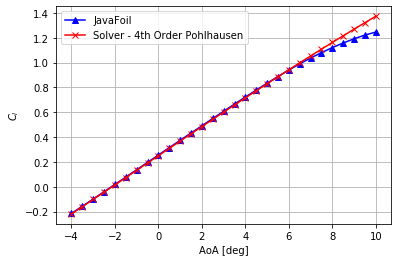

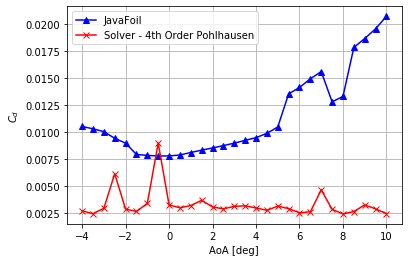

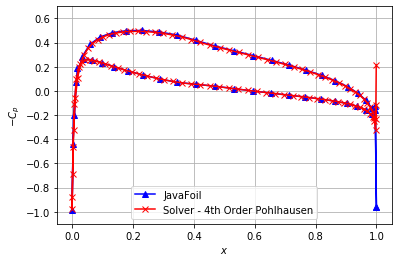

In [9]:
# Plot CL
plt.plot(AoA, Cl_Java, '-^b', label='JavaFoil')
plt.plot(AoA, Cl_solver, '-xr', label='Solver - 4th Order Pohlhausen')
plt.xlabel("AoA [deg]")
plt.ylabel("$C_{l}$")
plt.grid(which="both")
plt.legend()
plt.show()

# Plot Cd
plt.plot(AoA, Cd_Java, '-^b', label='JavaFoil')
plt.plot(AoA, Cd_solver, '-xr', label='Solver - 4th Order Pohlhausen')
plt.xlabel("AoA [deg]")
plt.ylabel("$C_{d}$")
plt.grid(which="both")
plt.legend()
plt.show()

# Plot CP

CpPlotJava = -Cp_java
plt.plot(X_java, CpPlotJava, '-^b', label='JavaFoil')
plt.plot(X, CpPlot, '-xr', label='Solver - 4th Order Pohlhausen')
plt.ylim([-1.1,0.7])
plt.xlabel("$x$")
plt.ylabel("$-C_{p}$")
plt.grid(which="both")
plt.legend()
plt.show()